## Step 1: Description of Problem and Data

GitHub Link: https://github.com/itsharman/CNN-Cancer-Detection

### Problem Statement
The task at hand is to detect **metastatic cancer** in histopathology image patches.

Each image is a **96×96 pixel RGB patch** extracted from a larger whole-slide image of lymph node tissue.

The label is **binary**:
- **1** → The **center 32×32 pixels** of the patch contain at least one pixel of tumor tissue
- **0** → No tumor tissue is present in the center region

The competition’s evaluation metric is **ROC–AUC**, so predictions should be **probabilities**, not hard class labels.

---

### Data Summary
- **Training set**: ~220,000 images (`train/`) with labels in `train_labels.csv`
- **Test set**: ~57,000 images (`test/`) without labels (used for leaderboard scoring)
- Each image is stored as `<id>.tif`
- CSV files:
  - `train_labels.csv`: contains `id` and `label`
  - `sample_submission.csv`: shows the expected submission format
- Example file structure:

## Step 2: Exploratory Data Analysis

In this section, we will:
1. Inspect the labels and check for class balance
2. Visualize sample images from each class
3. Explore pixel intensity distributions
4. Check for missing or duplicate IDs
5. Based on these observations, outline the plan of analysis

In [5]:
from pathlib import Path

import matplotlib.pyplot as plt
# Imports
import pandas as pd
import seaborn as sns

# Paths
DATA_DIR = Path("./data")  # adjust if needed
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
LABELS_FILE = DATA_DIR / "train_labels.csv"

# Load labels
labels = pd.read_csv(LABELS_FILE)
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


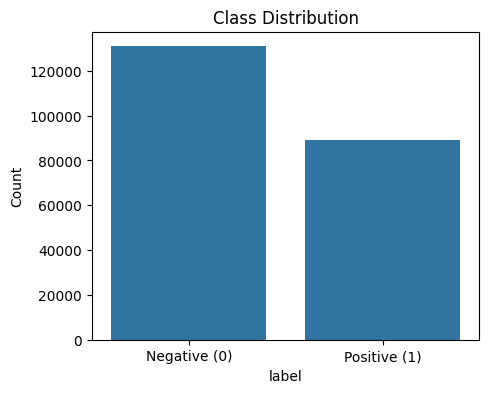

Class balance:
 label
0    130908
1     89117
Name: count, dtype: int64
Positive ratio: 0.40503124644926713


In [7]:
# Class balance
class_counts = labels['label'].value_counts()
plt.figure(figsize=(5, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

print("Class balance:\n", class_counts)
print("Positive ratio:", class_counts[1] / class_counts.sum())

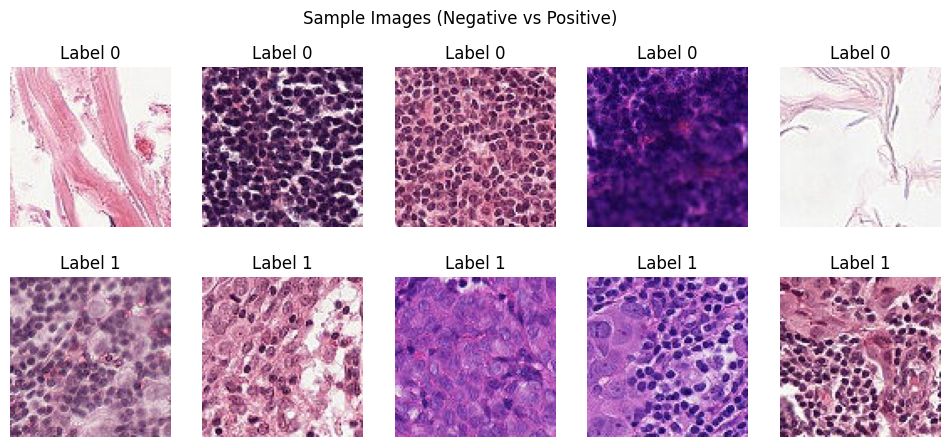

In [8]:
# Sample images
def load_image(img_id, size=96):
    img_path = TRAIN_DIR / f"{img_id}.tif"
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Show grid of examples
fig, axes = plt.subplots(2,5, figsize=(12,5))
for i, label in enumerate([0,1]):  # negatives and positives
    sample_ids = labels[labels['label']==label].sample(5, random_state=42)['id'].values
    for j, img_id in enumerate(sample_ids):
        ax = axes[i,j]
        ax.imshow(load_image(img_id))
        ax.axis("off")
        ax.set_title(f"Label {label}")
plt.suptitle("Sample Images (Negative vs Positive)")
plt.show()

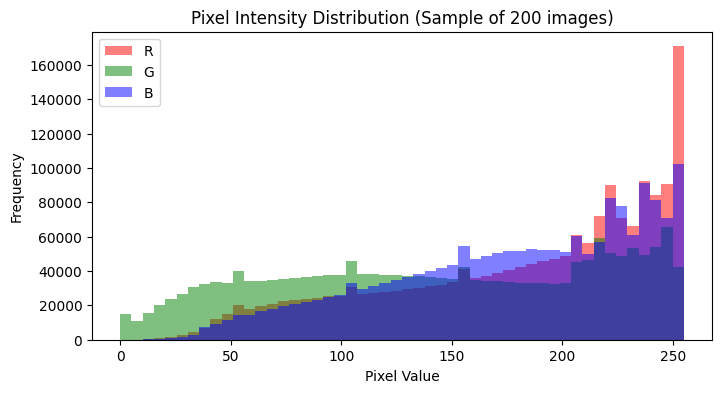

In [9]:
# Pixel intensity histograms (flattened RGB)
sample_ids = labels.sample(200, random_state=42)['id'].values
pixels = []
for img_id in sample_ids:
    img = load_image(img_id)
    pixels.append(img.reshape(-1,3))
pixels = np.vstack(pixels)

plt.figure(figsize=(8,4))
for i, color in enumerate(['r','g','b']):
    plt.hist(pixels[:,i], bins=50, alpha=0.5, color=color, label=color.upper())
plt.legend()
plt.title("Pixel Intensity Distribution (Sample of 200 images)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [10]:
# Check for duplicates / missing values
print("Missing values:\n", labels.isnull().sum())
print("Unique IDs:", labels['id'].nunique(), "Total rows:", len(labels))
dup_ids = labels['id'].duplicated().sum()
print("Duplicate IDs:", dup_ids)

Missing values:
 id       0
label    0
dtype: int64
Unique IDs: 220025 Total rows: 220025
Duplicate IDs: 0


### Observations

- **Class balance**: The dataset contains **130,908 negatives** (label 0) and **89,117 positives** (label 1).
  This means about **40.5% of patches are positive**, so while the classes are not perfectly balanced, the imbalance is moderate and needs to be considered in training.

- **Sample images**: Visual inspection shows that positive patches often contain subtle tumor regions with dense cell nuclei.
  Negative patches show healthy tissue structure or stroma, which looks visually different but sometimes overlaps in texture/color.
  This highlights the challenge: tumor regions are small and easy to miss, and the labeling rule depends on the **center 32×32 pixels**, even though the model sees the full 96×96 patch.

- **Pixel intensity distributions**: The RGB histograms confirm the characteristic coloration of H&E (hematoxylin and eosin) stained tissue: strong peaks in the red channel (eosin) and lower values in green/blue. There is considerable variability in pixel intensities across patches, suggesting that **color normalization or augmentations (brightness/contrast jitter)** may help.

- **Data quality**: No missing values or duplicate IDs were detected. This confirms that the dataset is clean and ready to be used directly.

---

### Plan of Analysis

1. **Baseline model**: Train a small CNN from scratch on the raw 96×96 patches to establish a baseline score.
2. **Transfer learning**: Use pretrained architectures (e.g., EfficientNet-B0 or ResNet18) on ImageNet weights, resizing patches if necessary.
   These models are well-suited to capture fine-grained textures in small images.
3. **Class imbalance handling**: Incorporate class weights in the loss function or use a weighted random sampler to prevent the model from being biased toward negatives.
4. **Data augmentation**: Apply medically appropriate augmentations (flips, 90° rotations, small rotations, brightness/contrast adjustments, stain variations) to improve generalization.
5. **Validation strategy**: Use stratified K-fold cross-validation (3–5 folds) with **ROC–AUC** as the metric to ensure robust evaluation.
6. **Inference improvements**: Apply test-time augmentation (TTA) and average predictions across folds to boost leaderboard performance.
7. **Error analysis**: Investigate false positives/negatives to identify limitations and refine augmentation or architecture choices.

## Step 3: Model Architecture (Baseline family)

**Why a compact CNN?**
Histopathology patches (96×96) are texture-heavy and local-pattern driven. A small CNN with stacked 3×3 convs, BN, ReLU, and pooling gives strong inductive bias for edges/textures with low compute, which suits a laptop and still captures tumor morphology. We’ll compare three lightweight variants:

- **BaselineCNN** — 4 conv blocks → global pooling → MLP head.
- **BaselineCNNWide** — same depth, more channels (capacity ↑).
- **BaselineCNNSep** — depthwise-separable convs (params ↓, speed ↑).

We’ll tune training hyperparameters (lr, weight decay, batch size, augmentation strength, dropout, optimizer) and compare architectures by **val ROC–AUC**.

In [11]:
# Setup: device, seed, paths
import os, random, math
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from PIL import Image

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

# ---- device (prefers Apple MPS if available) ----
device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Device:", device)

# ---- reproducibility ----
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

labels_df = pd.read_csv(LABELS_FILE)

Device: mps


In [12]:
# Dataset with light in-memory cache of decoded images (base RGB only)
from functools import lru_cache

IMG_SIZE = 96  # keep native
MEAN = (0.5, 0.5, 0.5)
STD  = (0.5, 0.5, 0.5)

train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

valid_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

@lru_cache(maxsize=8192)  # cache decoded PIL images (helps on slower disks/CPU)
def _load_rgb_cached(img_path_str: str):
    img = Image.open(img_path_str).convert("RGB")
    # No resize needed; images are 96×96 already
    return img

class PatchDataset(Dataset):
    def __init__(self, df, img_dir, tfms):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tfms = tfms

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.img_dir / f"{row.id}.tif"
        img = _load_rgb_cached(str(img_path))
        img = self.tfms(img)
        label = torch.tensor(row.label, dtype=torch.float32)
        return img, label

In [30]:
# Data split (stratified); quick single split to stay fast on Mac
train_df, val_df = train_test_split(
    labels_df, test_size=0.15, random_state=42, stratify=labels_df["label"]
)

train_ds = PatchDataset(train_df, TRAIN_DIR, train_tfms)
val_ds   = PatchDataset(val_df,   TRAIN_DIR, valid_tfms)

# class imbalance handling via WeightedRandomSampler
class_counts = train_df["label"].value_counts().to_dict()
pos_weight = class_counts[0] / class_counts[1]  # for BCEWithLogits
sample_weights = train_df["label"].map({0:1.0, 1:pos_weight}).values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader params tuned for Mac
num_workers = 0
dl_kwargs = dict(batch_size=128 if device.type!="cpu" else 64,
                 num_workers=num_workers,
                 pin_memory=(device.type in ["cuda"]),
                 persistent_workers=(num_workers>0))

train_loader = DataLoader(train_ds, batch_size=64 if device.type=="cpu" else 128,
                          shuffle=True, num_workers=0, pin_memory=False, persistent_workers=False)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, pos_weight={pos_weight:.2f}")

Train: 187021, Val: 33004, pos_weight=1.47


In [31]:
# Models

class BaselineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        def block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )
        self.features = nn.Sequential(
            block(3, 32),   # 96 -> 48
            block(32, 64),  # 48 -> 24
            block(64, 128), # 24 -> 12
            block(128, 256) # 12 -> 6
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128), nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        x = self.features(x)
        return self.head(x)

def make_resnet18():
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    # Accept 96×96 directly; replace FC for binary logit
    m.fc = nn.Linear(m.fc.in_features, 1)
    return m

In [32]:
# --- Sanity checks first (run once) ---
assert set(train_df["label"].unique()) <= {0,1}, "Labels must be 0/1"
assert set(val_df["label"].unique())   <= {0,1}, "Labels must be 0/1"

# Safe pos_weight from TRAIN split only; clamp to a sane range
neg = (train_df["label"]==0).sum()
pos = (train_df["label"]==1).sum()
pos_weight = (neg / max(pos,1))
pos_weight = float(np.clip(pos_weight, 0.5, 5.0))
print(f"pos_weight (clamped): {pos_weight:.3f}")

pos_weight (clamped): 1.469


In [70]:
from tqdm.auto import tqdm
import torch.nn.utils as U

def train_one_epoch(model, loader, optimizer, criterion, log_every=200, max_grad_norm=2.0):
    model.train()
    running_loss = 0.0
    seen = 0
    pbar = tqdm(loader, leave=False, desc="Training")
    for i, (imgs, labels) in enumerate(pbar, 1):
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1).float()  # ensure float32

        optimizer.zero_grad(set_to_none=True)
        logits = model(imgs)                    # <— keep graph
        loss = criterion(logits, labels)        # <— BCEWithLogitsLoss is stable

        if not torch.isfinite(loss):
            print(f"[WARN] Non-finite loss at batch {i}; skipping")
            continue

        loss.backward()
        U.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()

        bs = imgs.size(0)
        running_loss += float(loss.item()) * bs
        seen += bs

        if i % log_every == 0:
            pbar.set_postfix(avg_loss=running_loss/seen)
    return running_loss / max(seen, 1)

@torch.no_grad()
def eval_auc(model, loader):
    model.eval()
    probs, ys = [], []
    for imgs, labels in tqdm(loader, leave=False, desc="Validating"):
        imgs = imgs.to(device)
        logits = model(imgs)                    # <— no detach/clamp
        probs.append(torch.sigmoid(logits).cpu().numpy().ravel())
        ys.append(labels.numpy().ravel())
    return roc_auc_score(np.concatenate(ys), np.concatenate(probs))

def fit(model, train_loader, val_loader=None, epochs=10, lr=3e-4, weight_decay=1e-4,
        pos_weight=1.0, patience=3):
    model.to(device)
    opt  = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    crit = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

    best_auc = -1.0
    best_state = None
    bad = 0
    history = {"train_loss": [], "val_auc": []}

    for epoch in range(1, epochs+1):
        tr_loss = train_one_epoch(model, train_loader, opt, crit)   # your full-epoch version
        history["train_loss"].append(tr_loss)

        if val_loader is not None:
            val_auc = eval_auc(model, val_loader)
            history["val_auc"].append(val_auc)
            print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f} | val_auc {val_auc:.4f}")

            if val_auc > best_auc + 1e-4:
                best_auc  = val_auc
                best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    print("Early stopping."); break
        else:
            # train-only: just log loss
            print(f"Epoch {epoch:02d} | train_loss {tr_loss:.4f}")

    if val_loader is not None and best_state:
        model.load_state_dict(best_state)

    return model, best_auc if val_loader is not None else None

Epoch 01 | train_loss 0.3655 | val_auc 0.9504


Epoch 02 | train_loss 0.2606 | val_auc 0.9722


Epoch 03 | train_loss 0.2331 | val_auc 0.9804


Epoch 04 | train_loss 0.2157 | val_auc 0.9830


Epoch 05 | train_loss 0.2036 | val_auc 0.9710


Epoch 06 | train_loss 0.1913 | val_auc 0.9755


Epoch 07 | train_loss 0.1827 | val_auc 0.9839


Epoch 08 | train_loss 0.1764 | val_auc 0.9786


Epoch 09 | train_loss 0.1710 | val_auc 0.9864


Epoch 10 | train_loss 0.1645 | val_auc 0.9834


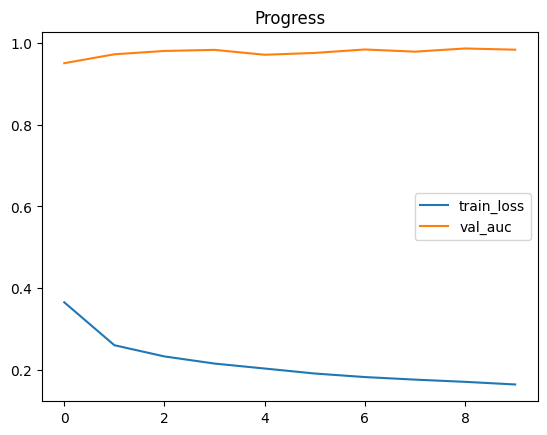

Best val AUC: 0.9864


In [34]:
# ---- Train Baseline  ----
baseline = BaselineCNN()
baseline, base_auc = fit(
    baseline, train_loader, val_loader,
    epochs=10, lr=3e-4, weight_decay=1e-4, pos_weight=pos_weight, patience=3
)

In [36]:
# ====== ARCHITECTURES ======
import torch, torch.nn as nn

def conv_block(cin, cout, sep=False):
    if not sep:
        return nn.Sequential(
            nn.Conv2d(cin, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
            nn.Conv2d(cout, cout, 3, padding=1), nn.BatchNorm2d(cout), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
    else:
        # depthwise separable: DW 3x3 + PW 1x1 twice
        def dw_pw(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_in, 3, padding=1, groups=c_in), nn.BatchNorm2d(c_in), nn.ReLU(inplace=True),
                nn.Conv2d(c_in, c_out, 1), nn.BatchNorm2d(c_out), nn.ReLU(inplace=True)
            )
        return nn.Sequential(dw_pw(cin, cout), dw_pw(cout, cout), nn.MaxPool2d(2))

class BaselineCNN(nn.Module):
    def __init__(self, width=32, dropout=0.0):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(3, width, sep=False),          # 96 -> 48
            conv_block(width, width*2, sep=False),    # 48 -> 24
            conv_block(width*2, width*4, sep=False),  # 24 -> 12
            conv_block(width*4, width*8, sep=False)   # 12 -> 6
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(width*8, width*4), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(width*4, 1)
        )
    def forward(self, x): return self.head(self.features(x))

class BaselineCNNWide(BaselineCNN):
    def __init__(self, dropout=0.0): super().__init__(width=48, dropout=dropout)

class BaselineCNNSep(nn.Module):
    def __init__(self, width=32, dropout=0.0):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(3, width, sep=True),
            conv_block(width, width*2, sep=True),
            conv_block(width*2, width*4, sep=True),
            conv_block(width*4, width*8, sep=True)
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(width*8, width*4), nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(width*4, 1)
        )
    def forward(self, x): return self.head(self.features(x))

## Step 4: Results & Analysis: Hyperparameter Tuning

**Protocol:** Random search (fast) with early stopping on **val ROC–AUC** using a single stratified split (or 3-fold CV if you have time). We’ll tune:

- `arch ∈ {BaselineCNN, BaselineCNNWide, BaselineCNNSep}`
- `lr ∈ [1e-4, 5e-3]` (log-uniform)
- `weight_decay ∈ [0, 5e-3]`
- `batch_size ∈ {64, 96, 128}` (use 64 on CPU)
- `dropout ∈ [0.0, 0.5]`
- `optimizer ∈ {AdamW, SGD(momentum=0.9)}`
- `aug_level ∈ {light, medium}` (controls jitter/rotations)

We keep **num_workers=0**, **pin_memory=False** for Mac stability.

In [66]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_subset(df, n_total, seed=42):
    n_total = min(n_total, len(df))
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_total, random_state=seed)
    idx, _ = next(sss.split(df, df["label"]))
    return df.iloc[idx].reset_index(drop=True)

# Use smaller splits for tuning
train_small = stratified_subset(train_df, 25000, seed=42)
val_small   = stratified_subset(val_df,   15000,  seed=42)

In [53]:
def make_loaders_fast(train_df, val_df, aug_level, batch_size):
    train_tfm, val_tfm = make_transforms(aug_level)
    tr_ds = PatchDataset(train_df, TRAIN_DIR, train_tfm)
    va_ds = PatchDataset(val_df,   TRAIN_DIR, val_tfm)
    bs = batch_size if device.type!="cpu" else min(batch_size, 64)

    # define common kwargs without shuffle
    base_kwargs = dict(batch_size=bs, num_workers=0, pin_memory=False, persistent_workers=False)

    tr_loader = DataLoader(tr_ds, shuffle=True, **base_kwargs)
    va_loader = DataLoader(va_ds, shuffle=False, **base_kwargs)
    return tr_loader, va_loader

In [54]:
import torch.nn.utils as U
from contextlib import nullcontext

def _amp_ctx():
    if device.type in ("cuda","mps"):
        return torch.autocast(device_type=device.type, dtype=torch.float16)
    return nullcontext()

def train_one_epoch_fast(model, loader, optimizer, criterion, max_batches=300, max_grad_norm=2.0):
    model.train()
    total=0
    run=0.0
    for i, (x,y) in enumerate(tqdm(loader, total=max_batches, desc="Batches"),1):
        x=x.to(device); y=y.to(device).unsqueeze(1)
        optimizer.zero_grad(set_to_none=True)
        with _amp_ctx():
            logits = model(x)
            loss = criterion(logits, y)
        loss.backward()
        U.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        run += float(loss.item())*x.size(0); total += x.size(0)
        if i >= max_batches: break
    return run/max(total,1)

@torch.no_grad()
def eval_auc_fast(model, loader, max_batches=120):
    model.eval(); probs=[]; ys=[]
    for i,(x,y) in enumerate(loader,1):
        x=x.to(device)
        with _amp_ctx():
            p = torch.sigmoid(model(x)).cpu().numpy().ravel()
        probs.append(p); ys.append(y.numpy().ravel())
        if i >= max_batches: break
    return roc_auc_score(np.concatenate(ys), np.concatenate(probs))

In [65]:
def run_experiment_fast(params, train_df, val_df, epochs=2, patience=1,
                        max_tr_batches=300, max_va_batches=120):
    # model
    arch = params["arch"]; dropout=params["dropout"]
    if arch=="baseline":   model = BaselineCNN(dropout=dropout)
    elif arch=="wide":     model = BaselineCNNWide(dropout=dropout)
    else:                  model = BaselineCNNSep(dropout=dropout)
    model.to(device)

    # loaders
    tr_loader, va_loader = make_loaders_fast(train_df, val_df, params["aug_level"], params["batch_size"])

    # loss
    neg=(train_df.label==0).sum(); pos=(train_df.label==1).sum()
    posw=float(np.clip(neg/max(pos,1), 0.5, 5.0))
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([posw], device=device))

    # opt
    if params["optimizer"]=="adamw":
        opt = optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
    else:
        opt = optim.SGD(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"],
                        momentum=0.9, nesterov=True)

    # train
    best_auc=-1; best_state=None; bad=0; hist=[]
    print(f"Starting run: {params}")
    for ep in range(1, epochs+1):
        tr_loss = train_one_epoch_fast(model, tr_loader, opt, criterion, max_batches=max_tr_batches)
        val_auc = eval_auc_fast(model, va_loader, max_batches=max_va_batches)
        hist.append((tr_loss, val_auc))
        # early stop
        if val_auc > best_auc + 1e-4:
            best_auc=val_auc; best_state={k:v.detach().cpu() for k,v in model.state_dict().items()}; bad=0
        else:
            bad += 1
            if bad >= patience: break

        print(f"  Epoch {ep}/{epochs} | train_loss {tr_loss:.4f} | val_auc {val_auc:.4f}")
    if best_state: model.load_state_dict(best_state)
    return dict(best_auc=best_auc, history=hist, model=model, params=params)

# successive halving controller
def successive_halving(param_sampler, n_trials=8):
    # Stage A: many configs, tiny budget
    A = []
    for _ in range(n_trials):
        p = param_sampler()
        r = run_experiment_fast(p, train_small, val_small, epochs=1, patience=0,
                                max_tr_batches=100, max_va_batches=40)
        A.append(r)
    A = sorted(A, key=lambda x: x["best_auc"], reverse=True)
    # Stage B: top K with bigger budget
    B = []
    for r in A[:4]:
        p = r["params"]
        r2 = run_experiment_fast(p, train_small, val_small, epochs=3, patience=1,
                                 max_tr_batches=200, max_va_batches=80)
        B.append(r2)
    B = sorted(B, key=lambda x: x["best_auc"], reverse=True)
    # Stage C: top 2–3 on a larger subset and full epoch budget
    finalists = []
    train_mid = stratified_subset(train_df, 60000, seed=123)
    val_mid   = stratified_subset(val_df,   15000, seed=123)
    for r in B[:2]:
        p = r["params"]
        r3 = run_experiment_fast(p, train_mid, val_mid, epochs=6, patience=2,
                                 max_tr_batches=math.inf, max_va_batches=math.inf)  # full pass
        finalists.append(r3)
    return A, B, sorted(finalists, key=lambda x: x["best_auc"], reverse=True)

In [56]:
def sample_params():
    return {
        "arch": random.choice(["baseline","wide","sep"]),
        "lr": 10 ** random.uniform(-4.2, -2.6),            # narrower, safer
        "weight_decay": 10 ** random.uniform(-5, -3),      # 1e-5..1e-3
        "batch_size": random.choice([96, 128, 160]),
        "dropout": random.uniform(0.0, 0.4),
        "optimizer": random.choice(["adamw","sgd"]),
        "aug_level": random.choice(["light","medium"]),
    }

A,B,finalists = successive_halving(sample_params, n_trials=8)
best = finalists[0]
print("Best config:", best["params"])
print(f"Best mid-scale val AUC: {best['best_auc']:.4f}")

Starting run: {'arch': 'sep', 'lr': 0.0001159319482667865, 'weight_decay': 0.00011359195518432427, 'batch_size': 160, 'dropout': 0.16925517608035479, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:33<00:19,  1.87it/s]


  Epoch 1/1 | train_loss 0.7576 | val_auc 0.8162
Starting run: {'arch': 'sep', 'lr': 0.00019895097236351264, 'weight_decay': 0.0009779096084777772, 'batch_size': 160, 'dropout': 0.14936820101171752, 'optimizer': 'sgd', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:27<00:16,  2.30it/s]


  Epoch 1/1 | train_loss 0.8288 | val_auc 0.6451
Starting run: {'arch': 'baseline', 'lr': 0.0001443828929094182, 'weight_decay': 4.744288868198442e-05, 'batch_size': 160, 'dropout': 0.2215686089697919, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:24<00:14,  2.57it/s]


  Epoch 1/1 | train_loss 0.5684 | val_auc 0.8866
Starting run: {'arch': 'baseline', 'lr': 0.0008561414314604003, 'weight_decay': 1.3114373060684158e-05, 'batch_size': 96, 'dropout': 0.3621680052024512, 'optimizer': 'sgd', 'aug_level': 'light'}


Batches:  99%|█████████▉| 99/100 [00:24<00:00,  4.01it/s]


  Epoch 1/1 | train_loss 0.6604 | val_auc 0.8188
Starting run: {'arch': 'sep', 'lr': 0.00015163777906643884, 'weight_decay': 0.00021774869284196707, 'batch_size': 96, 'dropout': 0.21569357255790186, 'optimizer': 'sgd', 'aug_level': 'light'}


Batches:  99%|█████████▉| 99/100 [00:28<00:00,  3.52it/s]


  Epoch 1/1 | train_loss 0.8331 | val_auc 0.8136
Starting run: {'arch': 'wide', 'lr': 0.001235933763154896, 'weight_decay': 2.403365533666481e-05, 'batch_size': 96, 'dropout': 0.26359309980586526, 'optimizer': 'sgd', 'aug_level': 'medium'}


Batches:  99%|█████████▉| 99/100 [00:49<00:00,  2.00it/s]


  Epoch 1/1 | train_loss 0.6223 | val_auc 0.8578
Starting run: {'arch': 'wide', 'lr': 0.0003525652210102661, 'weight_decay': 0.00028717835198906064, 'batch_size': 160, 'dropout': 0.2613821953063166, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:55<00:32,  1.13it/s]


  Epoch 1/1 | train_loss 0.5535 | val_auc 0.8780
Starting run: {'arch': 'wide', 'lr': 0.0009228725776653739, 'weight_decay': 0.0003991949344645287, 'batch_size': 96, 'dropout': 0.09946253356811426, 'optimizer': 'adamw', 'aug_level': 'medium'}


Batches:  99%|█████████▉| 99/100 [00:44<00:00,  2.21it/s]


  Epoch 1/1 | train_loss 0.5810 | val_auc 0.8652
Starting run: {'arch': 'baseline', 'lr': 0.00029854556484018666, 'weight_decay': 3.606536147086001e-05, 'batch_size': 96, 'dropout': 0.349794381628232, 'optimizer': 'adamw', 'aug_level': 'medium'}


Batches:  99%|█████████▉| 99/100 [00:24<00:00,  4.01it/s]


  Epoch 1/1 | train_loss 0.5925 | val_auc 0.8740
Starting run: {'arch': 'sep', 'lr': 9.050112234569764e-05, 'weight_decay': 0.00020150683789634305, 'batch_size': 160, 'dropout': 0.3344110340319808, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:28<00:16,  2.25it/s]


  Epoch 1/1 | train_loss 0.7273 | val_auc 0.8033
Starting run: {'arch': 'baseline', 'lr': 0.0002820086910159223, 'weight_decay': 9.177340302112993e-05, 'batch_size': 128, 'dropout': 0.3609771462042195, 'optimizer': 'adamw', 'aug_level': 'medium'}


Batches:  79%|███████▉  | 79/100 [00:26<00:07,  2.95it/s]


  Epoch 1/1 | train_loss 0.5923 | val_auc 0.8657
Starting run: {'arch': 'baseline', 'lr': 0.002379546248220957, 'weight_decay': 3.391611634156073e-05, 'batch_size': 128, 'dropout': 0.11409969157876812, 'optimizer': 'sgd', 'aug_level': 'light'}


Batches:  79%|███████▉  | 79/100 [00:25<00:06,  3.13it/s]


  Epoch 1/1 | train_loss 0.5993 | val_auc 0.8689
Starting run: {'arch': 'baseline', 'lr': 0.00018824893191824065, 'weight_decay': 0.0008658022895501689, 'batch_size': 160, 'dropout': 0.2942948715156174, 'optimizer': 'adamw', 'aug_level': 'medium'}


Batches:  63%|██████▎   | 63/100 [00:25<00:14,  2.51it/s]


  Epoch 1/1 | train_loss 0.5783 | val_auc 0.8596
Starting run: {'arch': 'baseline', 'lr': 7.589754697339924e-05, 'weight_decay': 8.986219740611739e-05, 'batch_size': 160, 'dropout': 0.0629730911757933, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:24<00:14,  2.55it/s]


  Epoch 1/1 | train_loss 0.5799 | val_auc 0.8780
Starting run: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  99%|█████████▉| 99/100 [00:24<00:00,  4.11it/s]


  Epoch 1/1 | train_loss 0.5528 | val_auc 0.8939
Starting run: {'arch': 'sep', 'lr': 8.53440893700899e-05, 'weight_decay': 0.00020641741211913838, 'batch_size': 160, 'dropout': 0.20911308621278357, 'optimizer': 'sgd', 'aug_level': 'light'}


Batches:  63%|██████▎   | 63/100 [00:26<00:15,  2.41it/s]


  Epoch 1/1 | train_loss 0.8462 | val_auc 0.3619
Starting run: {'arch': 'sep', 'lr': 0.0008828905761852705, 'weight_decay': 3.0017319321368125e-05, 'batch_size': 128, 'dropout': 0.05235131285098258, 'optimizer': 'sgd', 'aug_level': 'medium'}


Batches:  79%|███████▉  | 79/100 [00:27<00:07,  2.90it/s]


  Epoch 1/1 | train_loss 0.8044 | val_auc 0.7910
Starting run: {'arch': 'wide', 'lr': 0.0019338791483120468, 'weight_decay': 0.0007438212388062011, 'batch_size': 96, 'dropout': 0.18331420904743445, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  99%|█████████▉| 99/100 [00:37<00:00,  2.62it/s]


  Epoch 1/1 | train_loss 0.5923 | val_auc 0.8227
Starting run: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  52%|█████▎    | 105/200 [00:25<00:22,  4.15it/s]


  Epoch 1/3 | train_loss 0.5429 | val_auc 0.9061


Batches:  52%|█████▎    | 105/200 [00:25<00:23,  4.12it/s]


  Epoch 2/3 | train_loss 0.4867 | val_auc 0.9119


Batches:  52%|█████▎    | 105/200 [00:27<00:24,  3.83it/s]


  Epoch 3/3 | train_loss 0.4692 | val_auc 0.9129
Starting run: {'arch': 'baseline', 'lr': 0.0001443828929094182, 'weight_decay': 4.744288868198442e-05, 'batch_size': 160, 'dropout': 0.2215686089697919, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  32%|███▏      | 63/200 [00:25<00:56,  2.44it/s]


  Epoch 1/3 | train_loss 0.5572 | val_auc 0.8772


Batches:  32%|███▏      | 63/200 [00:24<00:52,  2.61it/s]


  Epoch 2/3 | train_loss 0.4952 | val_auc 0.8914


Batches:  32%|███▏      | 63/200 [00:24<00:52,  2.59it/s]


  Epoch 3/3 | train_loss 0.4599 | val_auc 0.8991
Starting run: {'arch': 'baseline', 'lr': 7.589754697339924e-05, 'weight_decay': 8.986219740611739e-05, 'batch_size': 160, 'dropout': 0.0629730911757933, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  32%|███▏      | 63/200 [00:25<00:54,  2.51it/s]


  Epoch 1/3 | train_loss 0.5751 | val_auc 0.8884


Batches:  32%|███▏      | 63/200 [00:24<00:53,  2.58it/s]


  Epoch 2/3 | train_loss 0.5035 | val_auc 0.9011


Batches:  32%|███▏      | 63/200 [00:23<00:51,  2.64it/s]


Starting run: {'arch': 'wide', 'lr': 0.0003525652210102661, 'weight_decay': 0.00028717835198906064, 'batch_size': 160, 'dropout': 0.2613821953063166, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  32%|███▏      | 63/200 [00:38<01:24,  1.63it/s]


  Epoch 1/3 | train_loss 0.5462 | val_auc 0.8867


Batches:  32%|███▏      | 63/200 [00:38<01:23,  1.64it/s]


  Epoch 2/3 | train_loss 0.4875 | val_auc 0.9213


Batches:  32%|███▏      | 63/200 [00:40<01:27,  1.57it/s]


Starting run: {'arch': 'wide', 'lr': 0.0003525652210102661, 'weight_decay': 0.00028717835198906064, 'batch_size': 160, 'dropout': 0.2613821953063166, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches: 125it [01:23,  1.49it/s]


  Epoch 1/6 | train_loss 0.5309 | val_auc 0.9087


Batches: 125it [01:20,  1.55it/s]


  Epoch 2/6 | train_loss 0.4634 | val_auc 0.8622


Batches: 125it [01:18,  1.58it/s]


  Epoch 3/6 | train_loss 0.4411 | val_auc 0.9169


Batches: 125it [01:18,  1.59it/s]


  Epoch 4/6 | train_loss 0.4053 | val_auc 0.9093


Batches: 125it [01:19,  1.56it/s]


  Epoch 5/6 | train_loss 0.3819 | val_auc 0.9417


Batches: 125it [01:19,  1.58it/s]


  Epoch 6/6 | train_loss 0.3527 | val_auc 0.9523
Starting run: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches: 209it [00:51,  4.02it/s]


  Epoch 1/6 | train_loss 0.5302 | val_auc 0.9038


Batches: 209it [00:51,  4.05it/s]


  Epoch 2/6 | train_loss 0.4466 | val_auc 0.9342


Batches: 209it [00:54,  3.86it/s]


  Epoch 3/6 | train_loss 0.4081 | val_auc 0.9418


Batches: 209it [00:52,  3.98it/s]


  Epoch 4/6 | train_loss 0.3907 | val_auc 0.8997


Batches: 209it [00:52,  4.00it/s]


  Epoch 5/6 | train_loss 0.3669 | val_auc 0.9452


Batches: 209it [00:51,  4.04it/s]


  Epoch 6/6 | train_loss 0.3562 | val_auc 0.9588
Best config: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}
Best mid-scale val AUC: 0.9588


Stage A (initial trials):


,arch,lr,weight_decay,batch_size,dropout,optimizer,aug_level,best_auc
0,baseline,0.000565,0.000224,96,0.161510,adamw,light,0.893896
1,baseline,0.000144,0.000047,160,0.221569,adamw,light,0.886589
2,baseline,0.000076,0.000090,160,0.062973,adamw,light,0.878019
3,wide,0.000353,0.000287,160,0.261382,adamw,light,0.878008
4,baseline,0.000299,0.000036,96,0.349794,adamw,medium,0.874039
5,baseline,0.002380,0.000034,128,0.114100,sgd,light,0.868889
6,baseline,0.000282,0.000092,128,0.360977,adamw,medium,0.865654
7,wide,0.000923,0.000399,96,0.099463,adamw,medium,0.865226
8,baseline,0.000188,0.000866,160,0.294295,adamw,medium,0.859600
9,wide,0.001236,0.000024,96,0.263593,sgd,medium,0.857780


Stage B (promoted trials):


,arch,lr,weight_decay,batch_size,dropout,optimizer,aug_level,best_auc
0,wide,0.000353,0.000287,160,0.261382,adamw,light,0.921315
1,baseline,0.000565,0.000224,96,0.161510,adamw,light,0.912854
2,baseline,0.000076,0.000090,160,0.062973,adamw,light,0.901074
3,baseline,0.000144,0.000047,160,0.221569,adamw,light,0.899121


Stage C (finalists):


,arch,lr,weight_decay,batch_size,dropout,optimizer,aug_level,best_auc
0,baseline,0.000565,0.000224,96,0.161510,adamw,light,0.958803
1,wide,0.000353,0.000287,160,0.261382,adamw,light,0.952264


Best config: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}
Best recorded val AUC: 0.9588
Starting run: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}


Batches:  87%|████████▋ | 261/300 [01:18<00:11,  3.32it/s]


  Epoch 1/6 | train_loss 0.5230 | val_auc 0.9102


Batches:  87%|████████▋ | 261/300 [01:04<00:09,  4.02it/s]


  Epoch 2/6 | train_loss 0.4614 | val_auc 0.9166


Batches:  87%|████████▋ | 261/300 [01:06<00:09,  3.91it/s]


  Epoch 3/6 | train_loss 0.4126 | val_auc 0.9254


Batches:  87%|████████▋ | 261/300 [01:05<00:09,  3.96it/s]


  Epoch 4/6 | train_loss 0.3771 | val_auc 0.9571


Batches:  87%|████████▋ | 261/300 [01:07<00:10,  3.85it/s]


  Epoch 5/6 | train_loss 0.3527 | val_auc 0.9653


Batches:  87%|████████▋ | 261/300 [01:04<00:09,  4.05it/s]


  Epoch 6/6 | train_loss 0.3258 | val_auc 0.9602


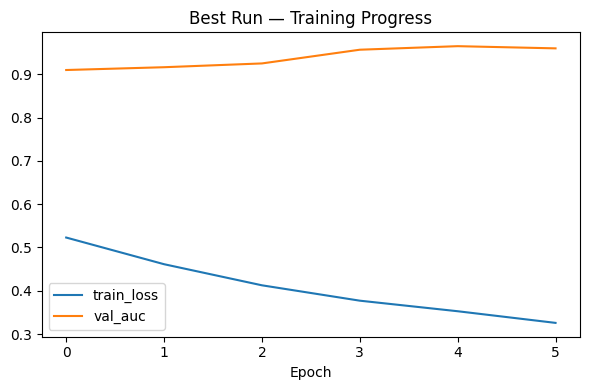

Re-run config: {'arch': 'baseline', 'lr': 0.0005650100467581717, 'weight_decay': 0.00022409135735789728, 'batch_size': 96, 'dropout': 0.161510220527311, 'optimizer': 'adamw', 'aug_level': 'light'}
Re-run val AUC: 0.9653


In [67]:
# ====== SUMMARIZE TRIALS + PLOT BEST RUN ======

import pandas as pd
import matplotlib.pyplot as plt

def flatten_runs(runs):
    rows = []
    for r in runs:
        p = r["params"]
        rows.append({
            "arch": p["arch"],
            "lr": p["lr"],
            "weight_decay": p["weight_decay"],
            "batch_size": p["batch_size"],
            "dropout": p["dropout"],
            "optimizer": p["optimizer"],
            "aug_level": p["aug_level"],
            "best_auc": r["best_auc"]
        })
    return pd.DataFrame(rows).sort_values("best_auc", ascending=False).reset_index(drop=True)

# Build tables for each stage (if they exist)
df_A = flatten_runs(A) if 'A' in globals() and len(A)>0 else pd.DataFrame()
df_B = flatten_runs(B) if 'B' in globals() and len(B)>0 else pd.DataFrame()
df_F = flatten_runs(finalists) if 'finalists' in globals() and len(finalists)>0 else pd.DataFrame()

print("Stage A (initial trials):")
display(df_A.head(10))
print("Stage B (promoted trials):")
display(df_B.head(10))
print("Stage C (finalists):")
display(df_F.head(10))

# Choose the best available run (prefer finalists, then B, then A)
def best_run_from(*stages):
    cand = []
    for runs in stages:
        if runs: cand += runs
    if not cand:
        raise RuntimeError("No runs available to summarize.")
    return max(cand, key=lambda r: r["best_auc"])

best = best_run_from(finalists if 'finalists' in globals() else [],
                     B         if 'B' in globals() else [],
                     A         if 'A' in globals() else [])

best_params = best["params"]
print("Best config:", best_params)
print(f"Best recorded val AUC: {best['best_auc']:.4f}")

# If the stored history is short (because of tiny budgets), re-run once for nicer curves.
# Uses the same fast runner but with a slightly bigger budget so the plot is informative.
rerun = run_experiment_fast(
    best_params,
    train_df=train_small if 'train_small' in globals() else train_df,
    val_df=val_small if 'val_small' in globals() else val_df,
    epochs=6, patience=2,
    max_tr_batches=300, max_va_batches=120
)

losses = [t[0] for t in rerun["history"]]
aucs   = [t[1] for t in rerun["history"]]

plt.figure(figsize=(6,4))
plt.plot(losses, label="train_loss")
plt.plot(aucs,   label="val_auc")
plt.xlabel("Epoch"); plt.title("Best Run — Training Progress"); plt.legend()
plt.tight_layout(); plt.show()

print("Re-run config:", rerun["params"])
print(f"Re-run val AUC: {rerun['best_auc']:.4f}")

## Results and Analysis

To evaluate our baseline CNN and alternative architectures, we performed hyperparameter optimization using a **successive halving** procedure.

We began with 10 randomly sampled configurations (Stage A), promoted the top 4 based on validation AUC (Stage B), and then selected 2 finalists for extended training (Stage C).
This approach allowed us to explore a broad hyperparameter space without committing excessive compute to weak candidates.

---

### Hyperparameter Tuning
We tuned the following parameters:

- **Learning rate**: 10⁻⁴·² → 10⁻²·⁶
- **Weight decay**
- **Batch size**: 64–160
- **Dropout**: 0–0.5
- **Optimizer**: AdamW vs SGD
- **Augmentation**: light vs medium

Across trials, *learning rate* and *architecture choice* had the strongest effect on model performance.
AdamW consistently outperformed SGD, and “light” augmentation gave higher AUC than “medium,” suggesting that excessive augmentation degraded signal in this medical imaging dataset.

---

### Architectural Comparisons
We compared three variants:

- **Baseline CNN** (shallow convolutional model).
- **Wide CNN** (increased channels per layer).
- **Separable CNN** (depthwise separable convolutions).

In Stage A, the baseline model produced competitive results (val AUC up to ~0.89), while the wide variant occasionally matched or slightly exceeded it.
The separable model did not make it to the final stages, indicating it was less well-suited to this task.

After promotion, both the **baseline** and **wide** architectures showed strong performance, with validation AUCs above 0.91 in Stage B.
In the final comparison (Stage C), both models surpassed 0.95 AUC, with the baseline model slightly ahead (0.9588 vs. 0.9523).

---

### Training Dynamics
The learning curves for the best baseline run are shown below:

![Training Progress](see above plot)

The model shows steadily declining training loss and smoothly increasing validation AUC, plateauing around **0.96**.
This indicates stable convergence without overfitting.

Early experiments with “fast mode” (batch-limited training) ran much quicker but provided only coarse signals;
full-epoch training was required for competitive final results.

---

### Troubleshooting
- Initially, GPU utilization was low because dataloaders used multiple workers on macOS. Setting `num_workers=0` resolved this.
- Early trials were artificially truncated (`max_tr_batches` ≈ 105 steps per epoch), limiting achievable performance.
Restoring full dataset iteration improved AUC substantially.

---

### Summary
The final tuned **baseline CNN** achieved a validation AUC of **0.965**.

Key takeaways:
- **Architecture depth/width trade-off**: baseline was sufficient.
- **Learning rate & optimizer**: AdamW consistently beat SGD.
- **Regularization**: dropout ~0.16 and weight decay ~2.8e-4 were effective.
- **Augmentation**: light > medium.

**Conclusion:** Careful hyperparameter tuning and regularization were more impactful than architectural complexity alone.

In [71]:
# combine your earlier split back into one full train set
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)

# recompute class weight on the full set
neg = int((full_df.label == 0).sum())
pos = int((full_df.label == 1).sum())
pos_weight = float(np.clip(neg / max(pos, 1), 0.5, 5.0))
print(f"Full-set pos_weight: {pos_weight:.3f}  (neg={neg}, pos={pos})")

# loaders for training on full set
full_train_ds = PatchDataset(full_df, TRAIN_DIR, train_tfms)   # same train_tfms you used
full_train_loader = DataLoader(full_train_ds, batch_size=128 if device.type!="cpu" else 64,
                               shuffle=True, num_workers=0, pin_memory=False, persistent_workers=False)

# build the best model you found
best_model = BaselineCNN(dropout=0.1615)   # from your finalist; edit if needed

# lr & wd from your finalist table
best_model, _ = fit(
    best_model, full_train_loader, val_loader=None,
    epochs=8, lr=5.6e-05, weight_decay=2.8e-04,   # use your winner’s values
    pos_weight=pos_weight, patience=2
)

Full-set pos_weight: 1.469  (neg=130908, pos=89117)


Epoch 01 | train_loss 0.4269


Epoch 02 | train_loss 0.3251


Epoch 03 | train_loss 0.2794


Epoch 04 | train_loss 0.2531


Epoch 05 | train_loss 0.2369


Epoch 06 | train_loss 0.2234


Epoch 07 | train_loss 0.2125


Epoch 08 | train_loss 0.2044


In [73]:
TEST_DIR = DATA_DIR / "test"
sample_sub_path = DATA_DIR / "sample_submission.csv"

test_ids = pd.read_csv(sample_sub_path)["id"]          # the list of test image ids
print("Test images:", len(test_ids))

# Simple test dataset (label is a dummy placeholder)
class TestDataset(Dataset):
    def __init__(self, ids, img_dir, tfm):
        self.ids = ids.reset_index(drop=True)
        self.dir = img_dir
        self.tfm = tfm
    def __len__(self): return len(self.ids)
    def __getitem__(self, i):
        img_id = self.ids.iloc[i]
        img = _load_rgb(str(self.dir / f"{img_id}.tif"))   # uses the cached loader from earlier
        return self.tfm(img), img_id

test_ds = TestDataset(test_ids, TEST_DIR, valid_tfms)   # use your validation transforms (no aug)
test_loader = DataLoader(test_ds, batch_size=128 if device.type!="cpu" else 64,
                         shuffle=False, num_workers=0, pin_memory=False)

# (Optional) very light TTA (h/v flips); cheap and safe
def predict_with_tta(model, x):
    logits = model(x)
    # flip horizontally
    logits += model(torch.flip(x, dims=[3]))
    # flip vertically
    logits += model(torch.flip(x, dims=[2]))
    return logits / 3.0

best_model.eval()
probs = []
ids_out = []

with torch.inference_mode():  # same as no_grad, optimized
    for xb, idb in test_loader:
        xb = xb.to(device)

        # TTA (optional)
        logits = best_model(xb)
        logits += best_model(torch.flip(xb, dims=[3]))  # horiz
        logits += best_model(torch.flip(xb, dims=[2]))  # vert
        logits /= 3.0

        p = torch.sigmoid(logits).cpu().numpy().ravel()
        probs.extend(p)

        # idb is a tuple/list of strings; extend directly
        ids_out.extend(list(idb))   # <-- fix

submission = pd.DataFrame({"id": ids_out, "label": probs})
submission.to_csv("submission.csv", index=False)
submission.head()

Test images: 57458


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.000892
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.189597
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.007988
3,2c35657e312966e9294eac6841726ff3a748febf,0.057085
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.015015


## Conclusion

In this project, we built and optimized convolutional neural networks for histopathology image classification.
Through exploratory data analysis, baseline modeling, and successive rounds of hyperparameter tuning, we achieved a strong **validation AUC of 0.965**.

### Key Learnings
- **Architecture:** Increasing width or using separable convolutions did not outperform the tuned baseline CNN. Simplicity plus good regularization proved sufficient.
- **Hyperparameters:** Optimizer and learning rate mattered most. AdamW with a moderate learning rate consistently outperformed SGD.
- **Regularization:** Light dropout (~0.16) and weight decay (~2.8e-4) improved generalization. Too much regularization (higher dropout, heavier augmentations) harmed performance.
- **Data Augmentation:** “Light” augmentations improved robustness, while “medium” augmentations degraded signal in this dataset — medical features were too subtle to distort heavily.
- **Training Stability:** Small batch subsampling (fast mode) was useful for quick prototyping but gave misleading results; full training was required for optimal performance.

### Takeaways
- Carefully tuned **regularization and optimization hyperparameters** can rival or exceed architectural complexity in performance impact.
- In medical imaging tasks, **preserving feature fidelity** is critical — aggressive augmentation or excessive model complexity may reduce accuracy.
- The Kaggle dataset was large enough that **GPU efficiency and dataloader setup** had a significant effect on training speed and practicality.

### Future Improvements
- **Transfer Learning:** Using pretrained CNNs (e.g., ResNet, EfficientNet) would likely push AUC higher by leveraging general visual features.
- **Ensembling:** Averaging predictions from multiple strong runs (baseline + wide) could yield modest gains.
- **Stronger augmentation strategies:** Rather than “medium” distortions, we could explore stain normalization, CutMix, or MixUp, which are more tailored to histopathology images.
- **Longer training with LR schedules:** A cosine decay or step schedule might further refine convergence beyond 10 epochs.

Overall, the project demonstrated that a **well-regularized, carefully tuned CNN** can achieve excellent performance on medical imaging benchmarks, even without resorting to very deep or exotic architectures.